## tf.data: TensorFlow 入力パイプラインの構築
- データセットを作成するには、次の 2 つの方法がある
  - データソースによって、メモリまたは 1 つ以上のファイルに格納されたデータから Dataset を作成する
  - データ変換によって、1 つ以上の tf.data.Dataset オブジェクトからデータセットを作成する

- [TensorFlowで使えるデータセット機能が強かった話](https://qiita.com/Suguru_Toyohara/items/820b0dad955ecd91c7f3)


In [1]:
import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4) # 小数点以下の桁数指定

### 入力パイプラインの作成
- Detaset の作成
  - tf.data.Dataset.from_tensors()
  - tf.data.Dataset.from_tensor_slices()
  - tf.data.TFRecordDataset()

- 新しい Dataset オブジェクトに変換
  - Dataset.map 要素ごとの変換を適用
  - Dataset.batch() 複数の要素に対する変換を適用

- Dataset オブジェクトは Python イテラブルで、for ループを使って、その要素を消費することができる

In [2]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
print(type(dataset))

for elem in dataset:
    print(elem, '->', elem.numpy(), elem.shape, elem.dtype)

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
tf.Tensor(8, shape=(), dtype=int32) -> 8 () <dtype: 'int32'>
tf.Tensor(3, shape=(), dtype=int32) -> 3 () <dtype: 'int32'>
tf.Tensor(0, shape=(), dtype=int32) -> 0 () <dtype: 'int32'>
tf.Tensor(8, shape=(), dtype=int32) -> 8 () <dtype: 'int32'>
tf.Tensor(2, shape=(), dtype=int32) -> 2 () <dtype: 'int32'>
tf.Tensor(1, shape=(), dtype=int32) -> 1 () <dtype: 'int32'>


- reduce 変換
  - 単一の結果を得るためにすべての要素が減らされる
  - 例では、整数のデータセットの合計を計算するために reduce 変換を使用している

In [3]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


### データセットの構造
- 要素ごとに同じ（ネスト）構造のコンポーネントを持つ一連の要素を生成
- 構造の各コンポーネントは tf.TypeSpec で表現可能な
  - tf.Tensor
  - tf.sparse.SparseTensor
  - tf.RaggedTensor
  - tf.TensorArray
  - tf.data.Dataset など、あらゆる型を持つことができます
- 各要素コンポーネントの型を検査するには、Dataset.element_spec プロパティを使用
- tf.TypeSpec オブジェクトのネストされた構造を、要素の構造を一致させて返す
- 単一のコンポーネント、コンポーネントのタプル、またはコンポーネントのネストされたタプルである場合がある
  - tf.sparse.SparseTensor(indices=[[0, 3], [2, 4]], values=[10, 20], dense_shape=[3, 10])
    <!-- - ![SparseTensor.png](../images/SparseTensor.png) -->

In [4]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
print(dataset1.element_spec)

dataset2 = tf.data.Dataset.from_tensor_slices(
    (tf.random.uniform([4]), tf.random.uniform([4, 100], maxval=100, dtype=tf.int32))
)
print(dataset2.element_spec)

dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
print(dataset3.element_spec)

TensorSpec(shape=(10,), dtype=tf.float32, name=None)
(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))
(TensorSpec(shape=(10,), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))


In [5]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(
    tf.sparse.SparseTensor(indices=[[0, 3], [2, 4]], values=[10, 20], dense_shape=[3, 10])
)
print(dataset4.element_spec)
# Use value_type to see the type of value represented by the element spec
print(dataset4.element_spec.value_type)


SparseTensorSpec(TensorShape([3, 10]), tf.int32)
<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


- Dataset 変換では、あらゆる構造のデータセットがサポートされている
- Dataset.map を使用し、各要素に関数を適用する Dataset.filter 変換を適用すると、要素の構造によって関数の引数が判定される

In [6]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

for z in dataset1:
    print(z.numpy())

[9 1 1 7 1 6 3 2 2 3]
[5 4 6 1 3 1 9 5 7 2]
[7 9 1 2 5 1 5 4 7 6]
[3 4 8 8 9 5 4 4 1 5]


In [7]:
dataset2 = tf.data.Dataset.from_tensor_slices((
    tf.random.uniform([4]),
    tf.random.uniform([4, 10], maxval=100, dtype=tf.int32)
))
print(dataset2)

for z in dataset2:
    # print(z)
    for i in z:
        print(i)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.int32, name=None))>
tf.Tensor(0.01894021, shape=(), dtype=float32)
tf.Tensor([30 13 36 86 19 28  4 93 79 37], shape=(10,), dtype=int32)
tf.Tensor(0.6443261, shape=(), dtype=float32)
tf.Tensor([31 12 44  6 31 68 49 20 19 44], shape=(10,), dtype=int32)
tf.Tensor(0.46158588, shape=(), dtype=float32)
tf.Tensor([73 49 51 43 43 99 12 83  4 98], shape=(10,), dtype=int32)
tf.Tensor(0.563434, shape=(), dtype=float32)
tf.Tensor([34 79 51 31  5 50 73 39 70  0], shape=(10,), dtype=int32)


In [8]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3

for a, (b,c) in dataset3:
  print(f'shapes: {a.shape}, {b.shape}, {c.shape}')

shapes: (10,), (), (10,)
shapes: (10,), (), (10,)
shapes: (10,), (), (10,)
shapes: (10,), (), (10,)


### 入力データの読み取り
- NumPy 配列のすべての入力データがメモリに収容できる場合
- このデータから Dataset を作成するには、データを tf.Tensor オブジェクトに変換して
- Dataset.from_tensor_slices を使用するのが最も簡単な方法である

In [16]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
images = images / 255
dataset = tf.data.Dataset.from_tensor_slices((images, labels))

dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [33]:
def count(stop):
    i = 0
    while i < stop:
        yield i
        i += 1


# for n in count(5):
#   print(n)

ds_counter = tf.data.Dataset.from_generator(
    count,
    args=[25],
    output_types=tf.int32,
    output_shapes=(),
)

for count_batch in ds_counter.repeat().batch(10).take(5):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


### tf.keras と tf.data を使用する
- tf.keras API は、機械学習モデルの作成や実行に関する多くの側面を単純化する
- その Model.fit、Model.evaluate、および Model.predict APIは、入力としてのデータセットをサポートする
- 簡単なデータセットとモデルのセットアップ(学習)を例に見る

In [58]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images / 255.0
labels = labels.astype(np.int32)

fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))

for a, b in fmnist_train_ds.take(2):
    print(f"shape: {a.shape}, label:{b}")

fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(64)
for a, b in fmnist_train_ds.take(2):
    print(f"shapes: {a.shape}, labels:{b}")

model = tf.keras.Sequential([tf.keras.layers.Flatten(), tf.keras.layers.Dense(10)])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# model.summary()

shape: (28, 28), label:9
shape: (28, 28), label:0
shapes: (64, 28, 28), labels:[9 1 8 7 6 1 0 2 9 5 9 3 0 5 7 4 7 4 6 8 4 1 0 3 2 1 1 5 6 5 9 5 6 9 2 5 2
 4 0 1 2 5 3 9 7 0 1 6 2 9 0 7 4 7 3 1 6 1 3 0 4 5 9 9]
shapes: (64, 28, 28), labels:[5 2 8 9 5 2 3 2 2 6 0 8 4 7 4 9 5 6 1 1 5 1 4 8 6 4 5 2 7 9 1 0 4 1 8 1 2
 9 7 4 2 7 3 9 2 9 0 7 6 3 1 4 6 4 1 4 5 5 2 1 8 6 4 2]


In [59]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7115 - loss: 0.8750
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8337 - loss: 0.4946


In [60]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.8422 - loss: 0.4779
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8404 - loss: 0.4547


In [61]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8475 - loss: 0.4549
Loss : 0.4529654085636139
Accuracy : 0.8477833271026611


## TensorFlowで使えるデータセット機能が強かった話
- Batchごとにデータを排出
- データをShuffleしながら排出
- データを指定回数 Repeat しながら排出
- チェインメソッドにより複雑に変形可能
- データを途中で変換掛けながら排出
- GPU演算中にCPUでデータセットを用意

データセットの作成

In [68]:
import tensorflow as tf
import tensorflow.keras as keras

dataset = tf.data.Dataset.from_tensor_slices(tf.range(3))
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [71]:
dataset = tf.data.Dataset.from_tensor_slices([i for i in range(3)])
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [79]:
dataset = tf.data.Dataset.from_tensor_slices((tf.range(3), tf.range(10, 13)))
for item1, item2 in dataset:
    print(item1, item2)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32) tf.Tensor(12, shape=(), dtype=int32)


In [82]:
datasetX = tf.data.Dataset.from_tensor_slices(tf.range(-3, 0))
datasetY = tf.data.Dataset.from_tensor_slices((tf.range(3), tf.range(10, 13)))
dataset = tf.data.Dataset.zip((datasetX, datasetY))
for itemX, (itemY1, itemY2) in dataset:
    print(itemX, itemY1, itemY2)

tf.Tensor(-3, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(-2, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(-1, shape=(), dtype=int32) tf.Tensor(2, shape=(), dtype=int32) tf.Tensor(12, shape=(), dtype=int32)


In [96]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(20)).batch(10)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)
tf.Tensor([10 11 12 13 14 15 16 17 18 19], shape=(10,), dtype=int32)


In [92]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(2)).repeat(3)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


In [97]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10)).repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [107]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(5)).shuffle(10)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


In [110]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(8)).map(lambda x: x**4)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32)
tf.Tensor(256, shape=(), dtype=int32)
tf.Tensor(625, shape=(), dtype=int32)
tf.Tensor(1296, shape=(), dtype=int32)
tf.Tensor(2401, shape=(), dtype=int32)


In [114]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(8)).map(lambda x: (x, x**2))
for item1, item2 in dataset:
    print(item1, item2)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32) tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32) tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32) tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32) tf.Tensor(36, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32) tf.Tensor(49, shape=(), dtype=int32)


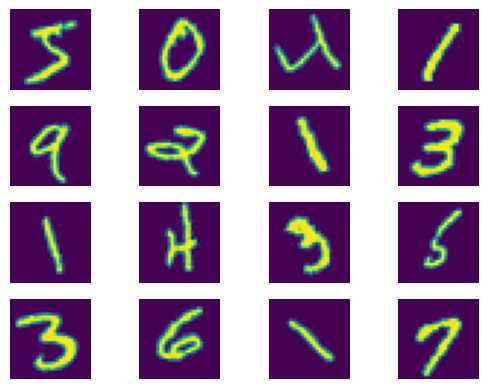

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

import tensorflow as tf
import tensorflow.keras as keras


def rotate(image):
    return ndimage.rotate(image, np.random.uniform(-45, 45), reshape=False)


@tf.function
def rotate_tf(image):
    rotated = tf.py_function(rotate, [image], [tf.int32])
    return rotated[0]


(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()
train_x = train_x.reshape(-1, 28, 28, 1)
train_ds = tf.data.Dataset.from_tensor_slices(train_x)
batched_train_ds = train_ds.map(rotate_tf).batch(16)  # ここが肝心のMap
# batched_train_ds = train_ds.batch(16)


# pick images in first batch
first_batch = next(iter(batched_train_ds))
sample_images = first_batch.numpy().reshape((-1, 28, 28))

plt.figure(facecolor="white")
for i, sample_image in enumerate(sample_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_image)
    plt.grid(False)
    plt.axis(False)
plt.show()